# Importing libraries

In [109]:
import warnings
# Don't display Future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import os
import re

from pickle import dump,load

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.optimizers import Adam

from keras.callbacks import EarlyStopping,ModelCheckpoint

#from keras.utils import plot_model
from keras.models import Model,load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.layers.merge import add
from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

## Load the cleaned descriptions

In [111]:
# Load the cleaned descriptions

train_descriptions = load(open("./saved_data/train_descriptions.pkl","rb"))
dev_descriptions = load(open("./saved_data/dev_descriptions.pkl","rb"))
test_descriptions = load(open("./saved_data/test_descriptions.pkl","rb"))

Our captions are in text format and we need to map these words to an unique integer values, for model to understand.

For this, I have used the **Keras Tokenizer class**, which can map each word to unique integer value.

In [112]:
# Create the tokenizer

def create_token(descriptions):
    
    # Create an empty list to store the descriptions text
    lines = list()
    
    for key in descriptions.keys():
        [lines.append(values) for values in descriptions[key]]
    
    total_images_to_train = len(lines)
        
    maximum_length = max(len(d.split()) for d in lines)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return total_images_to_train,maximum_length,tokenizer

In [113]:
# prepare tokenizer

total_images_to_train, maximum_length, tokenizer = create_token(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary Size: ',vocab_size)
print('Maximum length of description: ',maximum_length)
print('Total images for training: ', total_images_to_train)

Vocabulary Size:  7581
Maximum length of description:  34
Total images for training:  30000


In [114]:
# What does the tokenizer do
tokenizer.index_word #How the words are assigned to an unique integer values

{1: 'startseq',
 2: 'endseq',
 3: 'in',
 4: 'the',
 5: 'on',
 6: 'is',
 7: 'and',
 8: 'dog',
 9: 'with',
 10: 'man',
 11: 'of',
 12: 'two',
 13: 'white',
 14: 'black',
 15: 'boy',
 16: 'are',
 17: 'woman',
 18: 'girl',
 19: 'to',
 20: 'wearing',
 21: 'at',
 22: 'people',
 23: 'water',
 24: 'brown',
 25: 'red',
 26: 'young',
 27: 'an',
 28: 'his',
 29: 'blue',
 30: 'dogs',
 31: 'running',
 32: 'through',
 33: 'playing',
 34: 'while',
 35: 'down',
 36: 'shirt',
 37: 'ball',
 38: 'standing',
 39: 'little',
 40: 'grass',
 41: 'snow',
 42: 'child',
 43: 'person',
 44: 'jumping',
 45: 'over',
 46: 'three',
 47: 'sitting',
 48: 'front',
 49: 'field',
 50: 'holding',
 51: 'small',
 52: 'yellow',
 53: 'green',
 54: 'group',
 55: 'by',
 56: 'up',
 57: 'large',
 58: 'one',
 59: 'walking',
 60: 'her',
 61: 'men',
 62: 'children',
 63: 'air',
 64: 'into',
 65: 'near',
 66: 'mouth',
 67: 'beach',
 68: 'jumps',
 69: 'runs',
 70: 'another',
 71: 'for',
 72: 'street',
 73: 'from',
 74: 'its',
 75: 'rid

In [115]:
# Save the tokenizer
#dump(tokenizer,open("./saved_data/tokenizer.pkl","wb")) # Can save in pickle format too.

# Save the tokenizer
np.save('./saved_data/tokenizer.npy', tokenizer) 

# Load back using below command
tokenizer = np.load('./saved_data/tokenizer.npy',allow_pickle='TRUE').item()

In [116]:
# What does the tokenizer do
tokenizer.word_counts # shows the number of times a word has occurred

OrderedDict([('startseq', 30000),
             ('black', 2854),
             ('dog', 6158),
             ('is', 6904),
             ('running', 1587),
             ('after', 145),
             ('white', 2921),
             ('in', 14083),
             ('the', 13508),
             ('snow', 1173),
             ('endseq', 30000),
             ('chasing', 144),
             ('brown', 1995),
             ('through', 1533),
             ('two', 4246),
             ('dogs', 1618),
             ('chase', 29),
             ('each', 318),
             ('other', 566),
             ('across', 353),
             ('snowy', 318),
             ('ground', 274),
             ('play', 576),
             ('together', 315),
             ('low', 54),
             ('lying', 69),
             ('body', 142),
             ('of', 4964),
             ('water', 2024),
             ('little', 1266),
             ('baby', 322),
             ('plays', 392),
             ('croquet', 5),
             ('girl', 2414),
   

In [117]:
# Load the image_features extracted by Inceptionv3 and ResNet models.

train_image_extracted = np.load('./saved_data/train_image_extracted_inception.npy',allow_pickle='TRUE').item()
dev_image_extracted = np.load('./saved_data/dev_image_extracted_inception.npy',allow_pickle='TRUE').item()
test_image_extracted = np.load('./saved_data/test_image_extracted_inception.npy',allow_pickle='TRUE').item()

# Print 1st row of each to see if they are loaded properly
print("Sample of train image features")
print({k:v for k,v in list(train_image_extracted.items())[:1]})
print("\nSample of dev image features")
print({k:v for k,v in list(dev_image_extracted.items())[:1]})
print("\nSample of test image features")
print({k:v for k,v in list(test_image_extracted.items())[:1]})

Sample of train image features
{'2513260012_03d33305cf.jpg': array([0.08447927, 0.09467603, 0.09230011, ..., 0.0769059 , 1.4561858 ,
       0.45119157], dtype=float32)}

Sample of dev image features
{'2090545563_a4e66ec76b.jpg': array([0.05215571, 0.49605808, 0.7101982 , ..., 1.0289909 , 0.03897632,
       0.17930922], dtype=float32)}

Sample of test image features
{'3385593926_d3e9c21170.jpg': array([0.24057272, 0.13829081, 0.25790066, ..., 0.522944  , 1.2534735 ,
       0.52420866], dtype=float32)}


# Create sequence for each caption.

This is helpful in creating the input-output pairs of data required for training the model.

So, this function takes caption's array and image feature's array, and then outputs a word, which is the encoded next word in the text sequence.

This function to create_sequence, will take :<br>
**input :** tokenizer, maximum_length, descriptions(a dictionary) , image_features(a dictionary) , vocabulary_size<br>
**output :** encoded next word in sequence

_pad_sequences_ is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

![""](./images/text_to_sequence.png)



In [118]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, 
                     descriptions, photos, vocab_size):
    
    # set a counter, to show the output for only 1 image
    n = 0
    
    #photos is features extracted
    X1, X2, y = list(), list(), list()
    
    # walk through each image identifier
    for key, values in descriptions.items():
        
        # walk through each description for the image
        for desc in values:
            #print(desc)

            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            
            if n==0: 
                print("Text is : \n{}\ntext_to_sequence is: \n{}\n".format(desc,seq))
                print('Length of sequence is {}'.format(len(seq)))
                print("------------------------------------------------------------")
            
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                
                # pad input sequence
                in_seq_1 = pad_sequences([in_seq], maxlen=maximum_length)[0]
                
                # encode output sequence
                out_seq_1 = to_categorical([out_seq], num_classes=vocab_size)[0]

                if n ==0:

                    print('Input_sequence: {}'.format([tokenizer.index_word[in_seq[i]] for i in range(len(in_seq))]))
                    print('Input_sequence: {}'.format(in_seq))
                    print("Output sequence: {}".format(tokenizer.index_word[seq[i]]))
                    print('Output sequence: {}'.format(out_seq))
                    print('Input sequence(after padding):\n{}'.format(in_seq_1))
                    print('Output sequence (after categorical):\n{}\n'.format(out_seq_1))
            
                X1.append(photos[key])
                X2.append(in_seq_1)
                y.append(out_seq_1)
            n+=1
    return np.array(X1), np.array(X2), np.array(y)

In [119]:
# sequence for test image descriptions
X1train, X2train, ytrain = create_sequences(tokenizer, 
                                            maximum_length, 
                                            train_descriptions, 
                                            train_image_extracted,vocab_size)


Text is : 
startseq black dog is running after white dog in the snow endseq
text_to_sequence is: 
[1, 14, 8, 6, 31, 252, 13, 8, 3, 4, 41, 2]

Length of sequence is 12
------------------------------------------------------------
Input_sequence: ['startseq']
Input_sequence: [1]
Output sequence: black
Output sequence: 14
Input sequence(after padding):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'black']
Input_sequence: [1, 14]
Output sequence: dog
Output sequence: 8
Input sequence(after padding):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1 14]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'black', 'dog']
Input_sequence: [1, 14, 8]
Output sequence: is
Output sequence: 6
Input sequence(after padding):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

In [120]:
print("The shape of image (training set) features is: {}".format(X1train.shape))
print("The shape of text (training set) features is: {}".format(X2train.shape))

# There are 7581 unique words in the vocabulary.
print("The shape of next possible word (training set) features is: {}".format(ytrain.shape))


The shape of image (training set) features is: (306374, 2048)
The shape of text (training set) features is: (306374, 34)
The shape of next possible word (training set) features is: (306374, 7581)


In [121]:
X1test, X2test, ytest = create_sequences(tokenizer, 
                                            maximum_length, 
                                            dev_descriptions, 
                                            dev_image_extracted,vocab_size)

Text is : 
startseq the boy laying face down on skateboard is being pushed along the ground by another boy endseq
text_to_sequence is: 
[1, 4, 15, 259, 120, 35, 5, 132, 6, 174, 1703, 113, 4, 163, 55, 70, 15, 2]

Length of sequence is 18
------------------------------------------------------------
Input_sequence: ['startseq']
Input_sequence: [1]
Output sequence: the
Output sequence: 4
Input sequence(after padding):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'the']
Input_sequence: [1, 4]
Output sequence: boy
Output sequence: 15
Input sequence(after padding):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4]
Output sequence (after categorical):
[0. 0. 0. ... 0. 0. 0.]

Input_sequence: ['startseq', 'the', 'boy']
Input_sequence: [1, 4, 15]
Output sequence: laying
Output sequence: 259
Input sequence(after padding):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  

In [122]:
print("The shape of image (development set) features is: {}".format(X1test.shape))
print("The shape of text (development set) features is: {}".format(X2test.shape))

# There are 7581 unique words in the vocabulary.
print("The shape of next possible word (development set) features is: {}".format(ytest.shape))

The shape of image (development set) features is: (50903, 2048)
The shape of text (development set) features is: (50903, 34)
The shape of next possible word (development set) features is: (50903, 7581)


# Define the model for training.

Loss will be "categorical_entropy".<br>

To avoid overfitting the model, model will be validating on the development dataset, and will stop training the model, if validation_loss starts to increase.

**Input to model** : Image_features & encoded sequence (of texts - generated earlier)<br>
**Embedding layer** : Our vocabulary is discrete and by embedding we will be creating a map which will embed each word into a continuous vector space. Using this vector space representation it allow us to have a continuous  representation of our vocabulary words.

The first argument,_vocab_size_ is the number of distinct words in the training set. <br>
The second argument _256_ indicates the size of the embedding vectors. 

Once the network has been trained, we can get the weights of the embedding layer and can be thought as the table used to map integers to embedding vectors.<br>
**Output** : The next predicted word.

!["Overview of model"](./images/merge_model_overview.png)

In [123]:
# define the captioning model 

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))

    fe1 = Dropout(0.5)(inputs1)

    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(maximum_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    
    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=.0001),metrics=['accuracy'])
    
    # summarize model
    print(model.summary())
    
    return model

### NOTE: Below code of training the model takes approx 2 hours depending on your machine resources.

In [126]:
#define model

model = define_model(vocab_size, maximum_length)

# define checkpoint callback

# Save the files with today's date and time
filepath = './saved_data/model_inception_ep{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}_'+datetime.now().strftime("%d%m%Y_%H%M%S")+'.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# to stop model training, once validation_loss starts to increase.
early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=0)

# Fit the model
hist = model.fit([X1train, X2train], ytrain, 
                 epochs=20,
                 batch_size=64, #default is 32
                 verbose=1, 
                 callbacks=[checkpoint,early_stops], 
                 validation_data=([X1test, X2test], ytest))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 256)      1940736     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

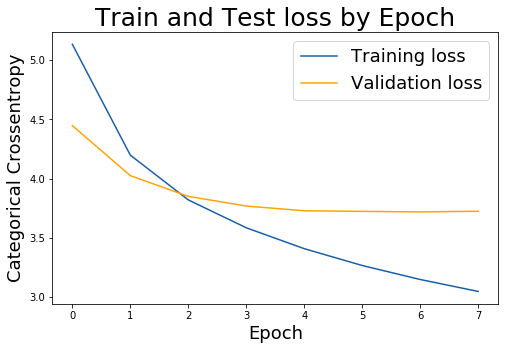

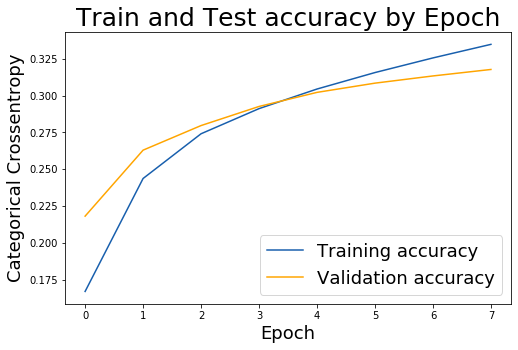

In [131]:
# Plot the loss and accuracy over epochs
def plot_model_history(metric):
    # Set figure size.
    plt.figure(figsize=(8, 5))

    # Generate line plot for loss and accuracy over epochs.
    
    plt.plot(hist.history[metric], label='Training '+metric, color='#185fad')
    plt.plot(hist.history["val_"+metric], label='Validation '+metric, color='orange')

    plt.title('Train and Test '+metric+' by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Categorical Crossentropy', fontsize = 18)

    plt.legend(fontsize = 18);

for metrics in ['loss','accuracy']:
    plot_model_history(metrics)

# Model evaluation

For model evaluation, I have used BLEU metric.

**BLEU score :**<br>
BLEU scores are used in text translation for evaluating translated text against one or more reference translations.
Closer the score to 1, better.


We have to generate the caption for the holdout test images and then compare the generated caption with the original captions.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

#### Generating the caption from the trained model

Model will output the probability of next words in sequence, we will take the "integer"(since, words were converted to integers) with maximum probablity and then with the help of tokenizer, will find what word it is.

The model will start predicting as soon as it sees "startseq" and will end prediction once "endseq" is reached.

In [132]:
# Function to find the word per its index from the tokenizer
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

In [133]:
# Generate the description for test data based on best-score model # Greedy search
def generate_description(model, tokenizer, features, maximum_length):
    
    #start generating the description
    input_word = 'startseq' 
    
    # The description shouldn't exceed the maximum length
    for i in range(maximum_length):
        
        # Get the integer code of input_word # Checkkkk
        sequence = tokenizer.texts_to_sequences([input_word])[0]
        
        # pad input
        sequence = pad_sequences([sequence], maxlen=maximum_length)
        
        # predict next word
        features1 = features.reshape(1,len(features))
        predicted_word = model.predict([features1, sequence], verbose=0)
        
        # Convert the probability of integer
        predicted_word =  np.argmax(predicted_word)
        
        # map_int_to_word
        word = index_word[predicted_word]
                    
        #Append as input for generating the next word
        input_word += ' ' + word
        
        # stop if we predict the end of sequence
        if word == 'endseq':
            break
    
    return input_word

In [134]:
def evaluate_model(model, descriptions, features, tokenizer, maximum_length):
    
    # Create empty lists to store the actual and predicted captions
    actual_full_list = []
    predicted_full_list = []
    
    image_name = []
    predicted_final=[]
    bleu_1gram =[]
    bleu_2gram =[]
    bleu_3gram =[]
    bleu_4gram =[]
    try_actual_final=[]
    
    for key, value in descriptions.items():
        
        actual=[]
        predicted=[]
        
        predicted_caption = generate_description(model, tokenizer, features[key] , maximum_length)
        
        words = [word.split() for word in value]
        actual.append(words)
        actual_full_list.append(words)
        
        predicted.append(predicted_caption.split())
        predicted_full_list.append(predicted_caption.split())
                
        bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
        bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
        bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
        
        image_name.append(key)
        try_actual_final.append(".\n".join(value))
        predicted_final.append(predicted_caption)
        bleu_1gram.append(bleu_1)
        bleu_2gram.append(bleu_2)
        bleu_3gram.append(bleu_3)
        bleu_4gram.append(bleu_4)
    
    BLEU_1 = corpus_bleu(actual_full_list, predicted_full_list, weights=(1.0, 0, 0, 0))
    BLEU_2 = corpus_bleu(actual_full_list, predicted_full_list, weights=(0.5, 0.5, 0, 0))
    BLEU_3 = corpus_bleu(actual_full_list, predicted_full_list, weights=(0.3, 0.3, 0.3, 0))
    BLEU_4 = corpus_bleu(actual_full_list, predicted_full_list, weights=(0.25, 0.25, 0.25, 0.25))
    
    print('BLEU-1: {:.4f}\nBLEU-2: {:.4f}\nBLEU-3: {:.4f}\nBLEU-4: {:.4f}'.format(BLEU_1,BLEU_2,BLEU_3,BLEU_4))
     
    return image_name,try_actual_final,predicted_final,bleu_1gram,bleu_2gram,bleu_3gram,bleu_4gram,BLEU_1,BLEU_2,BLEU_3,BLEU_4


**Load the various saved models to check which has maximum BLEU_score.**

Below are some models that I saved during various run-throughs having the highest BLEU_scores.

When features were extracted using **ResNet**: <br>
1. _model_resnet_ep001_loss5.211_val_loss4.644.h5_ <br>
BLEU-1: 0.554787<br>
BLEU-2: 0.267165


When features were extracted with **Inception** model: <br>
1. _model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5_ <br>
BLEU-1: 0.634521 <br>
BLEU-2: 0.405906 <br>
BLEU-3: 0.303920 <br>
BLEU-4: 0.168926 <br>
<br>
2. _model_inception_ep006_acc0.315_loss3.269_val_acc0.310_val_loss3.708.h5_ <br>
BLEU-1: 0.623100 <br>
BLEU-2: 0.394408 <br>
BLEU-3: 0.293830 <br>
BLEU-4: 0.162765 <br>


In [137]:
# Evaluate the model on development images

# Load the models with today's date created earlier

models_list = [f for f in os.listdir('./saved_data/') if datetime.now().strftime("%d%m%Y") in f]
models_list

['model_inception_ep004_acc0.291_loss3.584_val_acc0.293_val_loss3.768_23042020_164825.h5',
 'model_inception_ep002_acc0.244_loss4.197_val_acc0.263_val_loss4.024_23042020_164825.h5',
 'model_inception_ep001_acc0.167_loss5.133_val_acc0.218_val_loss4.447_23042020_164825.h5',
 'model_inception_ep007_acc0.326_loss3.147_val_acc0.313_val_loss3.718_23042020_164825.h5',
 'model_inception_ep003_acc0.274_loss3.820_val_acc0.280_val_loss3.849_23042020_164825.h5',
 'model_inception_ep005_acc0.304_loss3.408_val_acc0.302_val_loss3.728_23042020_164825.h5',
 'model_inception_ep006_acc0.316_loss3.265_val_acc0.308_val_loss3.723_23042020_164825.h5']

In [138]:
# Calculate the BLEU score for all different models having minimum val_loss.



# Create a dictionary with scores
models_bleu_scores = {}

for models in models_list:
    model_name = './saved_data/'+models
    print(model_name)
    model = load_model(model_name)
    print(model.summary)
    
    image_name,try_actual_final,predicted_final,bleu_1gram,bleu_2gram,bleu_3gram,bleu_4gram,BLEU_1,BLEU_2,BLEU_3,BLEU_4 = evaluate_model(model, 
                                                                                                dev_descriptions, 
                                                                                                dev_image_extracted, 
                                                                                                tokenizer, 
                                                                                                maximum_length)
    models_bleu_scores[models] = [round(BLEU_1,4),round(BLEU_2,4),round(BLEU_3,4),round(BLEU_4,4)]

./saved_data/model_inception_ep004_acc0.291_loss3.584_val_acc0.293_val_loss3.768_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x1433dadd0>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.5407
BLEU-2: 0.3328
BLEU-3: 0.2462
BLEU-4: 0.1282
./saved_data/model_inception_ep002_acc0.244_loss4.197_val_acc0.263_val_loss4.024_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x143405190>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.4667
BLEU-2: 0.2784
BLEU-3: 0.2052
BLEU-4: 0.1027
./saved_data/model_inception_ep001_acc0.167_loss5.133_val_acc0.218_val_loss4.447_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x1c6550f90>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.2000
BLEU-2: 0.1113
BLEU-3: 0.0788
BLEU-4: 0.0302
./saved_data/model_inception_ep007_acc0.326_loss3.147_val_acc0.313_val_loss3.718_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x1c0eaaa90>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.6251
BLEU-2: 0.3947
BLEU-3: 0.2956
BLEU-4: 0.1620
./saved_data/model_inception_ep003_acc0.274_loss3.820_val_acc0.280_val_loss3.849_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x1dd9eed10>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.6138
BLEU-2: 0.3760
BLEU-3: 0.2719
BLEU-4: 0.1393
./saved_data/model_inception_ep005_acc0.304_loss3.408_val_acc0.302_val_loss3.728_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x1e21f5a90>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.6117
BLEU-2: 0.3858
BLEU-3: 0.2867
BLEU-4: 0.1560
./saved_data/model_inception_ep006_acc0.316_loss3.265_val_acc0.308_val_loss3.723_23042020_164825.h5
<bound method Network.summary of <keras.engine.training.Model object at 0x1eedf1d50>>


/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.6294
BLEU-2: 0.4038
BLEU-3: 0.3022
BLEU-4: 0.1672


In [159]:
# Load the model with highest BLEU_score and check its predictions on the test data

#filename = 'model_inception_ep007_acc0.325_loss3.153_val_acc0.315_val_loss3.704.h5' # This one has the highest score
filename = [k for k,v in models_bleu_scores.items() if v==max(models_bleu_scores.values())][0]
print("The model with highest score is: \n\n{}".format(filename))

The model with highest score is: 

model_inception_ep006_acc0.316_loss3.265_val_acc0.308_val_loss3.723_23042020_164825.h5


In [126]:
# Load the model
model = load_model('./saved_data/'+filename)

print("The BLEU scores on test images.\n\n")

image_name,try_actual_final,predicted_final,bleu_1gram,bleu_2gram,bleu_3gram,bleu_4gram,BLEU_1,BLEU_2,BLEU_3,BLEU_4 = evaluate_model(model, 
                                                                                                test_descriptions, 
                                                                                                test_image_extracted, 
                                                                                                tokenizer, 
                                                                                                maximum_length)

The BLEU scores on test images.




/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/priya/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

BLEU-1: 0.634139
BLEU-2: 0.404242
BLEU-3: 0.301511
BLEU-4: 0.167285


In [139]:
# To display the entire row from the dataframe
pd.set_option('display.max_colwidth', -1)

In [140]:
# Create a dataframe
df = pd.DataFrame({'image_name':image_name,
                    'bleu_1gram':bleu_1gram,
                    'bleu_2gram':bleu_2gram,
                    'bleu_3gram':bleu_3gram,
                    'bleu_4gram':bleu_4gram,
                     'try_actual_final':try_actual_final,
                     'predicted_final':predicted_final
                })
df.head()

image_name  bleu_1gram     bleu_2gram     bleu_3gram  \
0  2090545563_a4e66ec76b.jpg  0.500000    1.961161e-01   1.904195e-93    
1  3393035454_2d2370ffd4.jpg  0.545455    2.335497e-01   2.114613e-93    
2  3695064885_a6922f06b2.jpg  0.322696    6.367734e-155  1.222720e-185   
3  1679557684_50a206e4a9.jpg  0.584101    3.605147e-01   2.482720e-93    
4  3582685410_05315a15b8.jpg  0.500000    3.396831e-01   3.056321e-01    

      bleu_4gram  \
0  6.605853e-155   
1  7.208781e-155   
2  8.945004e-232   
3  7.903999e-155   
4  2.044801e-01    

                                                                                                                                                                                                                                                                                                                                                                                                          try_actual_final  \
0  startseq the boy laying face down on skateboard is being pushed along the ground by another boy endseq.\nstartseq two girls play on skateboard in courtyard endseq.\nstartseq two people play on long skateboard endseq.\nstartseq two small children in red shirts playing on skateboard endseq.\nstartseq two young children on skateboard going across sidewalk endseq                                                 
1  startseq boy in blue top is jumping off some rocks in the woods endseq.\nstartseq boy jumps off tan rock endseq.\nstartseq boy jumps up in field in the woods endseq.\nstartseq young boy jumps off rock in the forest endseq.\nstartseq child in blue and grey shirt jumping off hill in the woods endseq                                                                                                                
2  startseq lady walking her dog through an obstacle course while other people are in the background endseq.\nstartseq small tan and white dog and trainer running an obstacle course endseq.\nstartseq woman is guiding brown dog around an obstacle course endseq.\nstartseq woman with hat is leading small dog through an obstacle course endseq.\nstartseq the woman is leading dog through an obstacle course endseq   
3  startseq big black dog jumps in the air to catch the tennis ball in his mouth endseq.\nstartseq dog looks at another dog catching ball in the air endseq.\nstartseq white dog is watching black dog jump on lawn next to pile of large rocks endseq.\nstartseq white dog watching black dog in the air endseq.\nstartseq two dogs playing with tennis ball in the yard endseq                                             
4  startseq two woman climbing rocks around the ocean endseq.\nstartseq two women are climbing over rocks near to the ocean endseq.\nstartseq two women climb on top of rocks in front of the ocean endseq.\nstartseq two women in bathing suit on large rocks at the ocean endseq.\nstartseq two women in bathing suits climb rock piles by the ocean endseq                                                                

                                                                 predicted_final  
0  startseq man in blue shirt and blue shirt is walking down the sidewalk endseq  
1  startseq man in red shirt is standing on rock rock endseq                      
2  startseq dog is jumping over hurdle endseq                                     
3  startseq dog is running on the grass endseq                                    
4  startseq man in bikini trunks is standing on the edge of the ocean endseq

# Display the image with predicted captions.

In [141]:
def plot_image(image):
    path='./data_1/image/'
    fig, ax = plt.subplots(figsize=(8, 5))
    filename = path+image
    
    image_load = load_img(filename)
    bleu1 = float(df[df['image_name']==image]['bleu_1gram'])
    bleu2 = float(df[df['image_name']==image]['bleu_2gram'])
    
    pred = df.predicted_final[df.image_name==image].values[0].replace('startseq','').replace('endseq','')
    actual = df.try_actual_final[df.image_name==image].values[0].replace('startseq','').replace('endseq','')

    # Prepare the string to display
    s = ("Image_name:{}\n\nBLEU(1gram): {:.3f}\nBLEU(2gram): {:.3f}\n\nPredicted caption:\n{}\n\nActual captions:\n{}".
         format(image,bleu1,bleu2,pred,actual))
    
    plt.axis('off')
    plt.imshow(image_load)
    plt.text(600, 310, s, fontsize=12)
    
    plt.show()

# Good captions

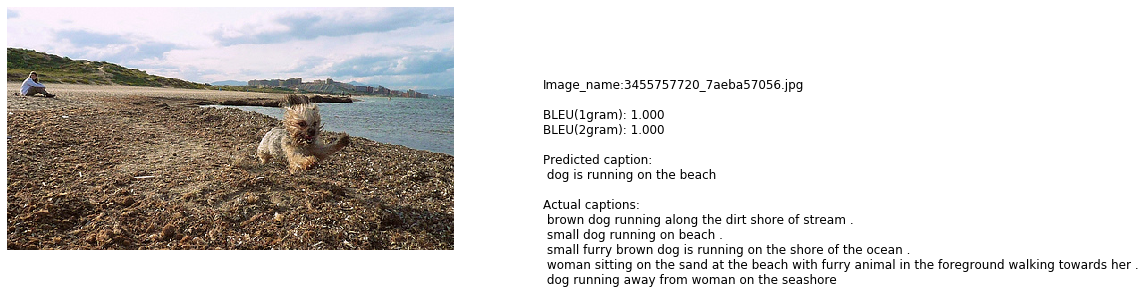

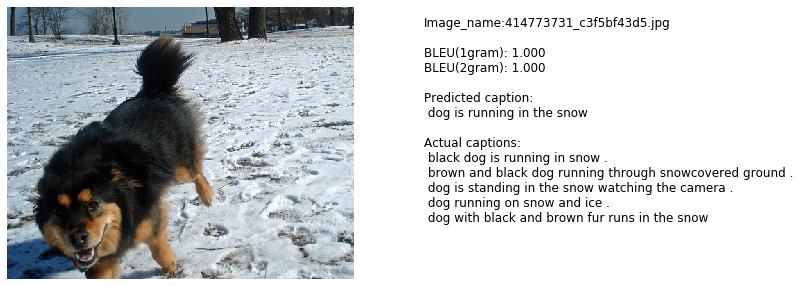

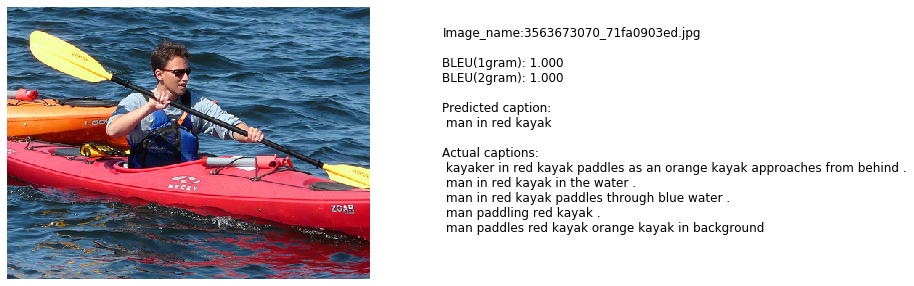

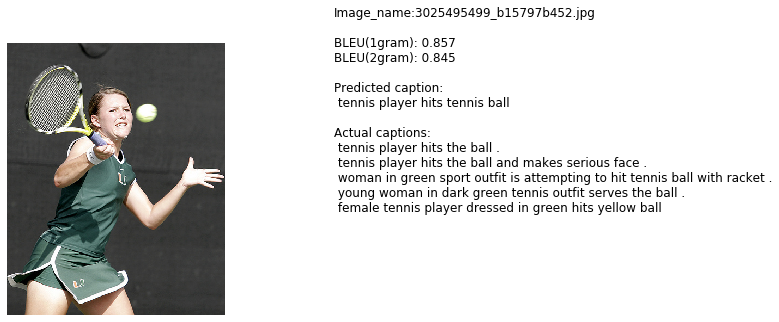

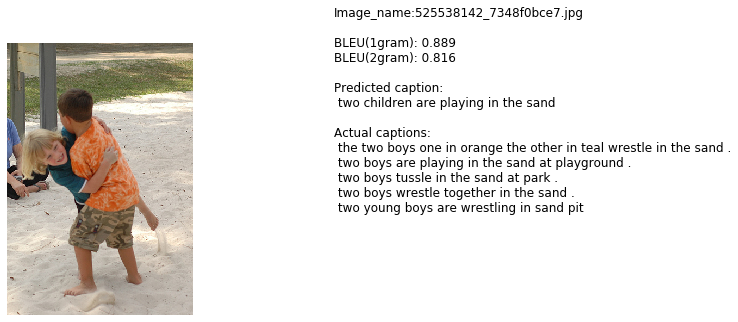

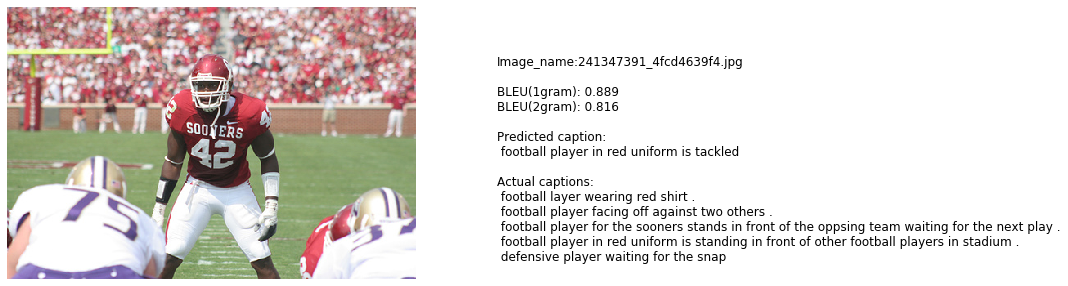

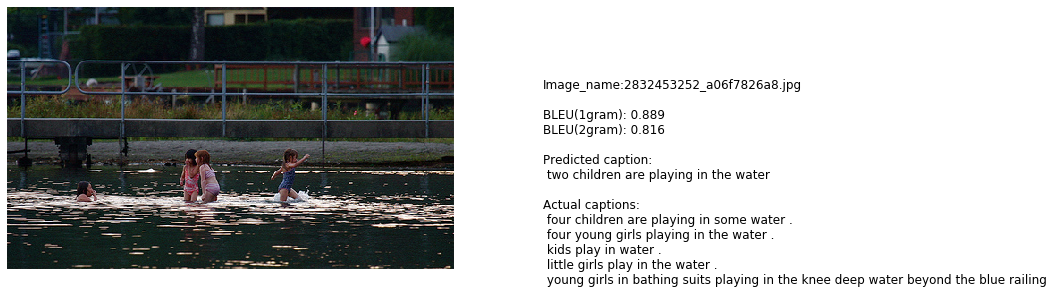

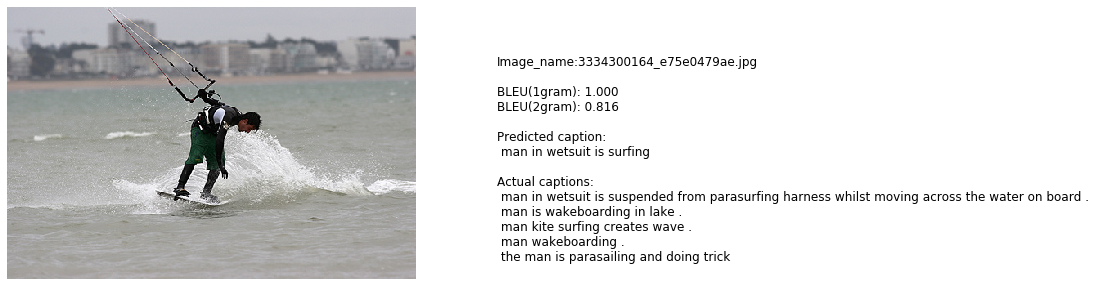

In [142]:
# Display images with highest BLEU scores.
for image in df.sort_values('bleu_2gram', ascending=False)['image_name'].head(2):
    plot_image(image)
    
for image in df[~df['try_actual_final'].str.contains('dog')].sort_values('bleu_2gram', ascending=False)['image_name'].head(6):
    plot_image(image)

# Bad captions

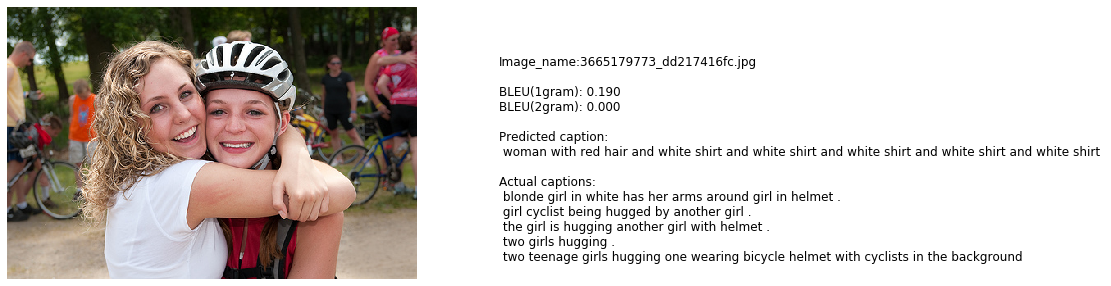

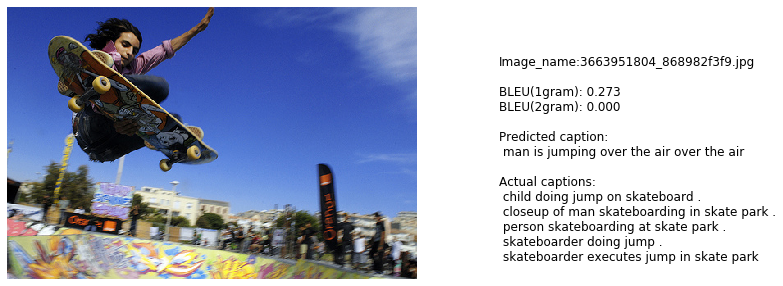

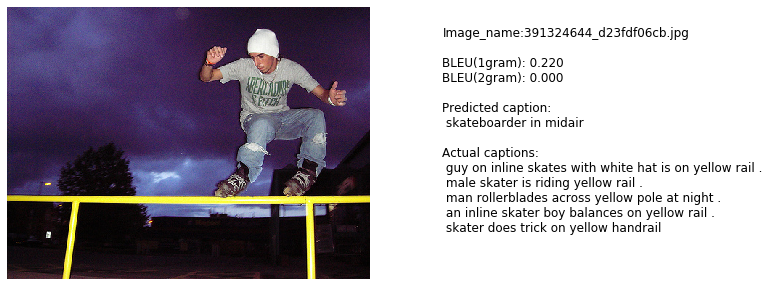

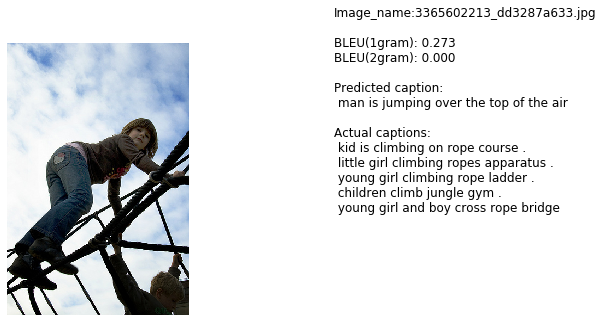

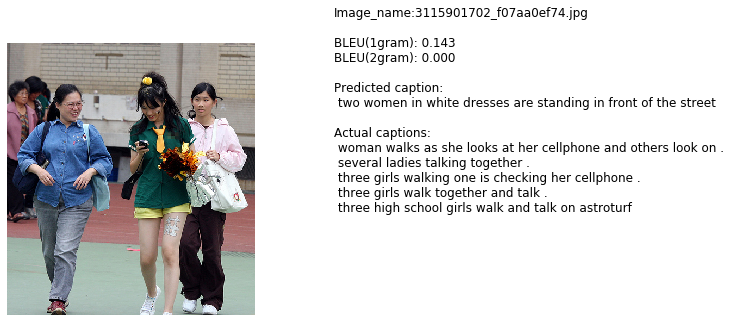

In [143]:
# provide filenames for least performace
for image in df[(df['bleu_1gram']>0.1) & (df['bleu_1gram']<0.3)]['image_name'].head():
    plot_image(image)

#### Beam search for caption prediction

Beam search is a breadth-first search algorithm that explores the most promising nodes. It generates all possible next paths, keeping only the top N best candidates at each iteration.

As the number of nodes to expand from is fixed, this algorithm is space-efficient and allows more potential candidates than a best-first search (The one with argmax - done above).

In [149]:
# Generate the description for test data based on best-score model
def beam_search_predict(model, tokenizer, features, maximum_length,beam_index):
    
    # create a list 
    in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]

    
    while len(in_text[0][0]) < maximum_length:
        templist=[]
        # The description shouldn't exceed the maximum length
        for seq in in_text:
        
            # pad input
            padded_seq = pad_sequences([seq[0]], maxlen=maximum_length)
            #print("Padded_seq", padded_seq)
        
            # Reshape the input and predict next word
            features1 = features.reshape(1,len(features))
            preds = model.predict([features1, padded_seq], verbose=0)
            
            # Top predictions
            top_preds =  np.argsort(preds[0])[-beam_index:]
        
            for word in top_preds:
                next_seq, prob = seq[0][:], seq[1]
                next_seq.append(word)
                #update probability
                prob += preds[0][word]
                # append as input for generating the next word
                templist.append([next_seq, prob])
                
        in_text = templist
        # Sorting according to the probabilities
        in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
        # Take the top words
        in_text = in_text[-beam_index:]
    in_text = in_text[-1][0]

    # Generate words from integers
    final_caption_raw = [index_word[i] for i in in_text]
    final_caption = []
    for word in final_caption_raw:
        if word=='endseq':
            break
        else:
            final_caption.append(word)
    final_caption.append('endseq')
    return ' '.join(final_caption)

In [153]:
# Define the function for evaluating the Beam_search performace.
def evaluate_model_beam(model, descriptions, features, tokenizer, maximum_length, beam_search):
    
    # Create empty lists to store the actual and predicted captions
    actual_full_list = []
    predicted_full_list = []
    
    image_name = []
    #actual_final=[]
    predicted_final=[]
    bleu_1gram =[]
    bleu_2gram =[]
    bleu_3gram =[]
    bleu_4gram =[]
    try_actual_final=[]
    
    for key, value in descriptions.items():
        
        actual=[]
        predicted=[]
        
        predicted_caption = beam_search_predict(model, tokenizer, test_image_extracted[key] , maximum_length, beam_search)

        
        words = [word.split() for word in value]
        actual.append(words)
        actual_full_list.append(words)
        
        predicted.append(predicted_caption.split())
        predicted_full_list.append(predicted_caption.split())
                
        bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
        bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
        bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
        
        image_name.append(key)
        #actual_final.append(value)
        try_actual_final.append(".\n".join(value))
        predicted_final.append(predicted_caption)
        bleu_1gram.append(bleu_1)
        bleu_2gram.append(bleu_2)
        bleu_3gram.append(bleu_3)
        bleu_4gram.append(bleu_4)
    
    BLEU_1 = corpus_bleu(actual_full_list, predicted_full_list, weights=(1.0, 0, 0, 0))
    BLEU_2 = corpus_bleu(actual_full_list, predicted_full_list, weights=(0.5, 0.5, 0, 0))
    BLEU_3 = corpus_bleu(actual_full_list, predicted_full_list, weights=(0.3, 0.3, 0.3, 0))
    BLEU_4 = corpus_bleu(actual_full_list, predicted_full_list, weights=(0.25, 0.25, 0.25, 0.25))
    
    print('BLEU-1: {:.4f}\nBLEU-2: {:.4f}\nBLEU-3: {:.4f}\nBLEU-4: {:.4f}'.format(BLEU_1,BLEU_2,BLEU_3,BLEU_4))    

In [154]:
# Calculate BLEU score on test images with k=3 , in beam_search

print("The BLEU scores on test images with beam search, k=3.\n\n")

evaluate_model_beam(model, test_descriptions, test_image_extracted, tokenizer, maximum_length, 3)

The BLEU scores on test images with beam search, k=3.


BLEU-1: 0.6296
BLEU-2: 0.4094
BLEU-3: 0.3082
BLEU-4: 0.1722


In [155]:
# Calculate BLEU score on test images with k=3 , in beam_search

print("The BLEU scores on test images with beam search, k=5.\n\n")

evaluate_model_beam(model, test_descriptions, test_image_extracted, tokenizer, maximum_length, 5)

The BLEU scores on test images with beam search, k=5.


BLEU-1: 0.6228
BLEU-2: 0.4040
BLEU-3: 0.3065
BLEU-4: 0.1739
